In [1]:
import pandas as pd
import numpy as np
import math
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import time, os
from pandas.io.html import read_html

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import datetime
from datetime import datetime as dt
import seaborn as sns

import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

from math import sqrt

import scipy.stats as stats

In [2]:
#----------------------------------------------
# Continuation from project_2_regression.ipynb
#----------------------------------------------

# Load pickled leages_df as new_leagues_df

with open('leagues_df.pickle','rb') as read_file:
    new_leagues_df = pickle.load(read_file)

In [3]:
new_leagues_df.describe()

POSITION        SQUAD      AVG_AGE   FOREIGNERS  \
count  1176.000000  1176.000000  1176.000000  1176.000000   
mean     10.316327    35.777211    24.626276    18.062075   
std       5.680150     7.096156     1.269075     6.752429   
min       1.000000    22.000000    21.100000     0.000000   
25%       5.000000    31.000000    23.800000    14.000000   
50%      10.000000    34.000000    24.500000    18.000000   
75%      15.000000    39.000000    25.400000    22.000000   
max      20.000000    88.000000    29.500000    57.000000   

       TOTAL_MARKET_VALUE (m€)  AVG_MARKET_VALUE (m€)         YEAR  \
count              1176.000000            1176.000000  1176.000000   
mean                177.211947               5.066304  2014.500000   
std                 190.570029               5.604451     3.453521   
min                  13.750000               0.463000  2009.000000   
25%                  61.482500               1.710000  2011.750000   
50%                 105.390000               2.960000  2014.500000   
75%                 213.747500               6.082500  2017.250000   
max                1270.000000              41.740000  2020.000000   

                 P            W            D  ...           YC           RC  \
count  1176.000000  1176.000000  1176.000000  ...  1176.000000  1176.000000   
mean     37.090136    13.856293     9.377551  ...    62.529762     3.880102   
std       1.963160     5.834360     2.945804  ...    23.393379     2.268394   
min      27.000000     2.000000     2.000000  ...    10.000000     0.000000   
25%      38.000000    10.000000     7.000000  ...    54.000000     2.000000   
50%      38.000000    12.000000     9.000000  ...    65.500000     4.000000   
75%      38.000000    17.000000    11.000000  ...    78.000000     5.000000   
max      38.000000    33.000000    19.000000  ...    99.000000     9.000000   

       SHOTS_OT_PG  DRIBBLES_PG    FOULED_PG  SHOTS_PG_DEF   TACKLES_PG  \
count  1176.000000  1176.000000  1176.000000   1176.000000  1176.000000   
mean      4.407143     8.860969    12.985629     12.760034    18.872364   
std       1.004619     2.528466     2.087198      2.139358     2.764282   
min       2.400000     3.000000     7.300000      6.200000    12.000000   
25%       3.700000     7.000000    11.500000     11.300000    16.900000   
50%       4.200000     8.600000    12.900000     12.800000    18.900000   
75%       4.900000    10.400000    14.400000     14.200000    20.725000   
max       8.600000    20.300000    21.900000     20.400000    27.200000   

       INTERCEPTIONS_PG     FOULS_PG  OFFSIDES_PG  
count       1176.000000  1176.000000  1176.000000  
mean          15.468878    13.696344     2.275680  
std            4.407495     2.243886     0.605805  
min            7.900000     8.300000     0.800000  
25%           11.900000    12.100000     1.900000  
50%           15.200000    13.700000     2.200000  
75%           18.200000    15.300000     2.600000  
max           36.800000    21.000000     4.600000  

[8 rows x 29 columns]

In [4]:
# Get yearly average of all features
# Identify features that trend with Total Market value and Average market value

year_list = []

# Value stats
market_value_avg = []
avg_market_value_avg = []
age_avg = []

# Summary stats
pts_avg = []
gf_avg = []
ga_avg = []
gd_avg = []
yc_avg = []
rc_avg = []
possession_pct_avg = []
pass_pct_avg = []
aerials_won_avg = []

# Offensive stats
shots_pg_avg = []
shots_ot_avg = []
dribbles_pg_avg = []
fouled_pg_avg = []

# Defensive stats
tackles_pg_avg = []
interceptions_pg_avg = []
fouls_pg_avg = []
offsides_pg_avg = []
shots_pg_def_avg = []

for yr in range(2009,2021):
    year_list.append(yr)
    
for yr in range(2009,2021):
    mask = new_leagues_df['YEAR'] == yr
    
    # Value stats
    market_value = new_leagues_df[mask]['TOTAL_MARKET_VALUE (m€)'].mean()
    market_value_avg.append(market_value)
    avg_market_value = new_leagues_df[mask]['AVG_MARKET_VALUE (m€)'].mean()
    avg_market_value_avg.append(avg_market_value)
    age = new_leagues_df[mask]['AVG_AGE'].mean()
    age_avg.append(age)
    
    # Summary stats
    pts = new_leagues_df[mask]['POINTS'].mean()
    pts_avg.append(pts)
    gf = new_leagues_df[mask]['GF'].mean()
    gf_avg.append(gf)
    ga = new_leagues_df[mask]['GA'].mean()
    ga_avg.append(ga)
    gd = new_leagues_df[mask]['GD'].mean()
    gd_avg.append(gd)   
    yc = new_leagues_df[mask]['YC'].mean()
    yc_avg.append(yc)    
    rc = new_leagues_df[mask]['RC'].mean()
    rc_avg.append(rc) 
    possession_pct = new_leagues_df[mask]['POSSESSION_PERCENT'].mean()
    possession_pct_avg.append(possession_pct)    
    pass_pct = new_leagues_df[mask]['PASS_PERCENT'].mean()
    pass_pct_avg.append(pass_pct)
    aerials_won = new_leagues_df[mask]['AERIALS_WON'].mean()
    aerials_won_avg.append(aerials_won)
    
    # Offensive state
    shots_pg = new_leagues_df[mask]['SHOTS_PG'].mean()
    shots_pg_avg.append(shots_pg)
    shots_ot = new_leagues_df[mask]['SHOTS_OT_PG'].mean()
    shots_ot_avg.append(shots_ot)    
    dribbles_pg = new_leagues_df[mask]['DRIBBLES_PG'].mean()
    dribbles_pg_avg.append(dribbles_pg)    
    fouled_pg = new_leagues_df[mask]['FOULED_PG'].mean()
    fouled_pg_avg.append(fouled_pg) 
    
    # Defensive stats
    tackles_pg = new_leagues_df[mask]['TACKLES_PG'].mean()
    tackles_pg_avg.append(tackles_pg)
    interceptions_pg = new_leagues_df[mask]['INTERCEPTIONS_PG'].mean()
    interceptions_pg_avg.append(interceptions_pg)
    fouls_pg = new_leagues_df[mask]['FOULS_PG'].mean()
    fouls_pg_avg.append(fouls_pg)
    offsides_pg = new_leagues_df[mask]['OFFSIDES_PG'].mean()
    offsides_pg_avg.append(offsides_pg)   
    shots_pg_def = new_leagues_df[mask]['SHOTS_PG_DEF'].mean()
    shots_pg_def_avg.append(shots_pg_def) 
    

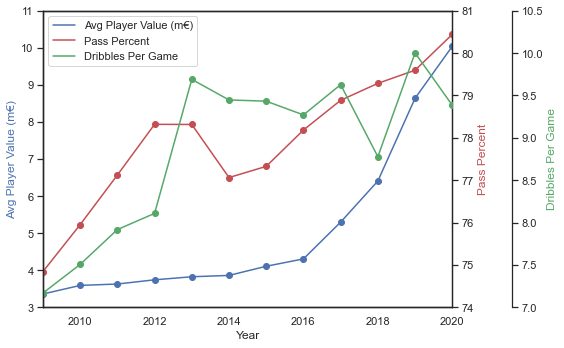

In [5]:
# Plot mean offensive stats

sns.set_theme(style="white")
fig, ax0 = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
ax1 = ax0.twinx()
ax2 = ax0.twinx()
    
ax0.set_xlim(2009, 2020)
ax0.set_ylim(3, 11)
ax1.set_ylim(74, 81)
ax2.set_ylim(7, 10.5)
    
ax0.set_xlabel("Year")
ax0.set_ylabel("Avg Player Value (m€)")
ax1.set_ylabel("Pass Percent")
ax2.set_ylabel("Dribbles Per Game")

p1,  = ax0.plot(year_list,avg_market_value_avg, "bo")
p1,  = ax0.plot(year_list,avg_market_value_avg, "b-",   label="Avg Player Value (m€)")
p2,  = ax1.plot(year_list,pass_pct_avg,         "ro")
p2,  = ax1.plot(year_list,pass_pct_avg,         "r-",   label="Pass Percent")
p3,  = ax2.plot(year_list,dribbles_pg_avg,      "go")
p3,  = ax2.plot(year_list,dribbles_pg_avg,      "g-",   label="Dribbles Per Game")

lns = [p1, p2, p3]
ax0.legend(handles=lns, loc='best')

# right, left, top, bottom
ax2.spines['right'].set_position(('outward', 60))

# no x-ticks                 
#ax2.xaxis.set_ticks([])

# Sometimes handy, same for xaxis
#ax2.yaxis.set_ticks_position('right')

ax0.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_color(p3.get_color())

# Adjust spacings w.r.t. figsize
fig.tight_layout()
# Alternatively: bbox_inches='tight' within the plt.savefig function 
#                (overwrites figsize)

# Best for professional typesetting, e.g. LaTeX
plt.savefig("offensive_stats.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'

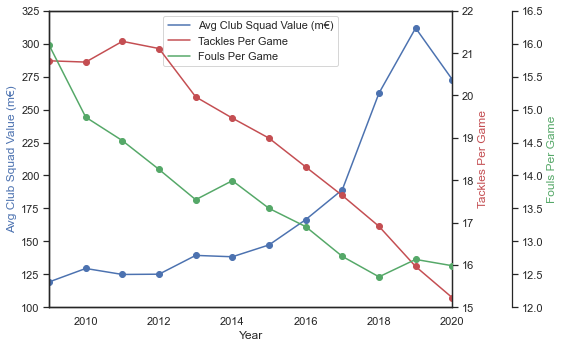

In [6]:
# Plot mean defensive stats
sns.set_theme(style="white")
fig, ax0 = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
ax1 = ax0.twinx()
ax2 = ax0.twinx()
    
ax0.set_xlim(2009, 2020)
ax0.set_ylim(100, 325)
ax1.set_ylim(15, 22)
ax2.set_ylim(12, 16.5)
    
ax0.set_xlabel("Year")
ax0.set_ylabel("Avg Club Squad Value (m€)")
ax1.set_ylabel("Tackles Per Game")
ax2.set_ylabel("Fouls Per Game")

p1, = ax0.plot(year_list,market_value_avg, "bo")
p1, = ax0.plot(year_list,market_value_avg, "b-",   label="Avg Club Squad Value (m€)")
p2, = ax1.plot(year_list,tackles_pg_avg,   "ro")
p2, = ax1.plot(year_list,tackles_pg_avg,   "r-",   label="Tackles Per Game")
p3, = ax2.plot(year_list,fouls_pg_avg,     "go")
p3, = ax2.plot(year_list,fouls_pg_avg,     "g-",   label="Fouls Per Game")

lns = [p1, p2, p3]
ax0.legend(handles=lns, loc='upper center') # loc='best'

# right, left, top, bottom
ax2.spines['right'].set_position(('outward', 60))

# no x-ticks                 
#ax2.xaxis.set_ticks([])

# Sometimes handy, same for xaxis
#ax2.yaxis.set_ticks_position('right')

ax0.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_color(p3.get_color())

# Adjust spacings w.r.t. figsize
fig.tight_layout()
# Alternatively: bbox_inches='tight' within the plt.savefig function 
#                (overwrites figsize)

# Best for professional typesetting, e.g. LaTeX
plt.savefig("defensive_stats.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'

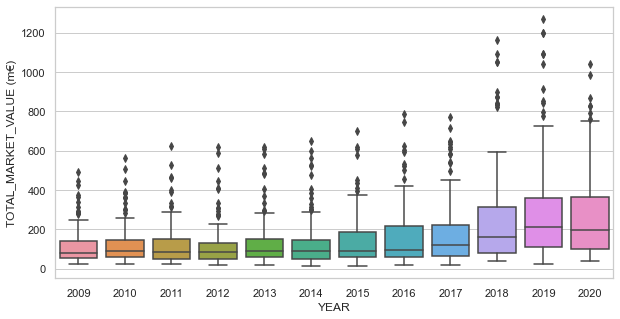

In [7]:
# 
# Box plot of Total Market Value (squad values)
# Notice that as total market value is increasing because average player value is increasing.
#
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
market_value_yr_df = new_leagues_df[['YEAR','TOTAL_MARKET_VALUE (m€)']]
ax = sns.boxplot(x=market_value_yr_df['YEAR'], y=market_value_yr_df['TOTAL_MARKET_VALUE (m€)'], data =market_value_yr_df )

In [8]:
#-------------------------------------
# REGRESSION ANALYSIS FOR ALL LEAGUES
#-------------------------------------

# Create a list of columns to keep.  These are the numeric columns.
subset=['TOTAL_MARKET_VALUE (m€)', 'AVG_MARKET_VALUE (m€)', 'P', 'W',
       'D', 'L', 'GF', 'GA', 'GD', 'SHOTS_PG', 'POSSESSION_PERCENT',
       'PASS_PERCENT', 'AERIALS_WON', 'YC', 'RC', 'SHOTS_OT_PG', 'DRIBBLES_PG',
       'FOULED_PG', 'SHOTS_PG_DEF', 'TACKLES_PG', 'INTERCEPTIONS_PG',
       'FOULS_PG', 'OFFSIDES_PG', 'POINTS']

new_leagues_df1 = new_leagues_df[subset]
new_leagues_df1.head()

TOTAL_MARKET_VALUE (m€)  AVG_MARKET_VALUE (m€)   P   W   D   L   GF  GA  \
0                   443.90                  13.45  38  27   5   6  103  32   
1                   362.95                  11.00  38  27   4   7   86  28   
2                   281.00                   6.24  38  23   6   9   83  41   
3                   249.20                   6.08  38  21   7  10   67  41   
4                   314.90                   7.87  38  18  13   7   73  45   

   GD  SHOTS_PG  ...  RC  SHOTS_OT_PG  DRIBBLES_PG  FOULED_PG  SHOTS_PG_DEF  \
0  71      21.9  ...   5          7.6          8.6       12.3           9.8   
1  58      18.3  ...   4          5.8          8.7       11.7          10.9   
2  42      17.4  ...   1          6.1         11.9       14.0          10.1   
3  26      17.9  ...   1          5.9          9.0       13.2          13.7   
4  28      13.8  ...   2          5.1          7.7       12.8          13.5   

   TACKLES_PG  INTERCEPTIONS_PG  FOULS_PG  OFFSIDES_PG  POINTS  
0        20.3              18.6      12.4          2.5      86  
1        21.8              15.8      11.7          2.2      85  
2        21.5              22.1      12.4          2.4      75  
3        22.2              21.2      12.2          3.1      70  
4        21.1              21.2      11.9          3.2      67  

[5 rows x 24 columns]

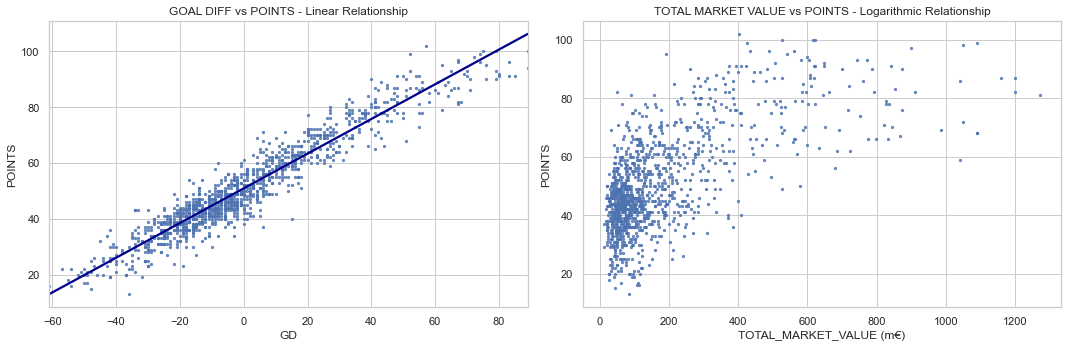

In [9]:
# Look at relationship between Goal Difference and points scored
#
# Goal Difference vs POINTS - linear relationship exists
# Total Market Value vs POINTS - Logarithmic/Curvi-linear relationship
# Total Market Value vs Goal Difference - Logarithmic/Curvi-linear relationship

mv_pts = new_leagues_df1[['TOTAL_MARKET_VALUE (m€)','GD','POINTS']]

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

g1 = sns.regplot(data=mv_pts,x=mv_pts['GD'], y = mv_pts['POINTS'], ci=False, fit_reg=True, line_kws={'color': 'darkblue'}, ax=axes[0], scatter_kws={'s': 5})
g1.set_title('GOAL DIFF vs POINTS - Linear Relationship')

g2 = sns.regplot(data=mv_pts,x=mv_pts['TOTAL_MARKET_VALUE (m€)'], y = mv_pts['POINTS'], ci=False, fit_reg=False, line_kws={'color': 'darkblue'}, ax=axes[1], scatter_kws={'s': 5})
g2.set_title('TOTAL MARKET VALUE vs POINTS - Logarithmic Relationship')

#g2 = sns.regplot(data=mv_pts,x=mv_pts['TOTAL_MARKET_VALUE (m€)'], y = mv_pts['GD'], ci=False, fit_reg=False, line_kws={'color': 'darkblue'}, ax=axes[1], scatter_kws={'s': 5})
#g2.set_title('TOTAL MARKET VALUE vs POINTS - Logarithmic Relationship')

fig.tight_layout();

In [10]:
# build correlations
new_leagues_df1.corr()

TOTAL_MARKET_VALUE (m€)  AVG_MARKET_VALUE (m€)  \
TOTAL_MARKET_VALUE (m€)                 1.000000               0.963564   
AVG_MARKET_VALUE (m€)                   0.963564               1.000000   
P                                       0.043317               0.019587   
W                                       0.666571               0.656732   
D                                      -0.265595              -0.267810   
L                                      -0.565613              -0.562366   
GF                                      0.674345               0.669403   
GA                                     -0.459361              -0.458931   
GD                                      0.668020               0.664574   
SHOTS_PG                                0.555740               0.524267   
POSSESSION_PERCENT                      0.648663               0.633590   
PASS_PERCENT                            0.629798               0.614169   
AERIALS_WON                            -0.122707              -0.118378   
YC                                      0.022297              -0.001648   
RC                                     -0.192228              -0.204718   
SHOTS_OT_PG                             0.622653               0.609940   
DRIBBLES_PG                             0.410024               0.405022   
FOULED_PG                              -0.250563              -0.240347   
SHOTS_PG_DEF                           -0.460850              -0.475816   
TACKLES_PG                             -0.299410              -0.314622   
INTERCEPTIONS_PG                       -0.354045              -0.348600   
FOULS_PG                               -0.451897              -0.440360   
OFFSIDES_PG                             0.008931               0.004340   
POINTS                                  0.654807               0.644215   

                                P         W         D         L        GF  \
TOTAL_MARKET_VALUE (m€)  0.043317  0.666571 -0.265595 -0.565613  0.674345   
AVG_MARKET_VALUE (m€)    0.019587  0.656732 -0.267810 -0.562366  0.669403   
P                        1.000000  0.116378  0.202790  0.128561  0.088231   
W                        0.116378  1.000000 -0.378824 -0.840478  0.885462   
D                        0.202790 -0.378824  1.000000 -0.063177 -0.305449   
L                        0.128561 -0.840478 -0.063177  1.000000 -0.766191   
GF                       0.088231  0.885462 -0.305449 -0.766191  1.000000   
GA                       0.119010 -0.724453 -0.004462  0.837398 -0.508029   
GD                      -0.000986  0.937008 -0.197703 -0.914686  0.905167   
SHOTS_PG                -0.013749  0.676957 -0.241892 -0.610997  0.740190   
POSSESSION_PERCENT      -0.002135  0.724603 -0.223011 -0.669177  0.742018   
PASS_PERCENT             0.029263  0.606960 -0.189020 -0.547899  0.638191   
AERIALS_WON             -0.202154 -0.208688  0.003919  0.151466 -0.236543   
YC                       0.082963 -0.005334  0.044395  0.011833  0.003287   
RC                       0.213990 -0.160589  0.073390  0.213554 -0.170359   
SHOTS_OT_PG             -0.087667  0.781367 -0.305113 -0.717330  0.866298   
DRIBBLES_PG             -0.290146  0.356280 -0.255783 -0.354686  0.413406   
FOULED_PG               -0.136851 -0.038336  0.085554 -0.055599 -0.041255   
SHOTS_PG_DEF            -0.011016 -0.598316  0.101789  0.593266 -0.504373   
TACKLES_PG              -0.055403 -0.042563  0.036222  0.006151 -0.070298   
INTERCEPTIONS_PG         0.033737 -0.105906  0.067753  0.090702 -0.132925   
FOULS_PG                -0.124442 -0.277879  0.140176  0.180454 -0.310579   
OFFSIDES_PG              0.009645  0.192701 -0.021604 -0.194998  0.199024   
POINTS                   0.157291  0.986095 -0.221759 -0.896866  0.878582   

                               GA        GD  SHOTS_PG  ...        RC  \
TOTAL_MARKET_VALUE (m€) -0.459361  0.668020  0.555740  ... -0.192228   
AVG_MARKET_VALUE (m€)   -0.458931  0.664574  0.524267  ... -0.204718   
P      

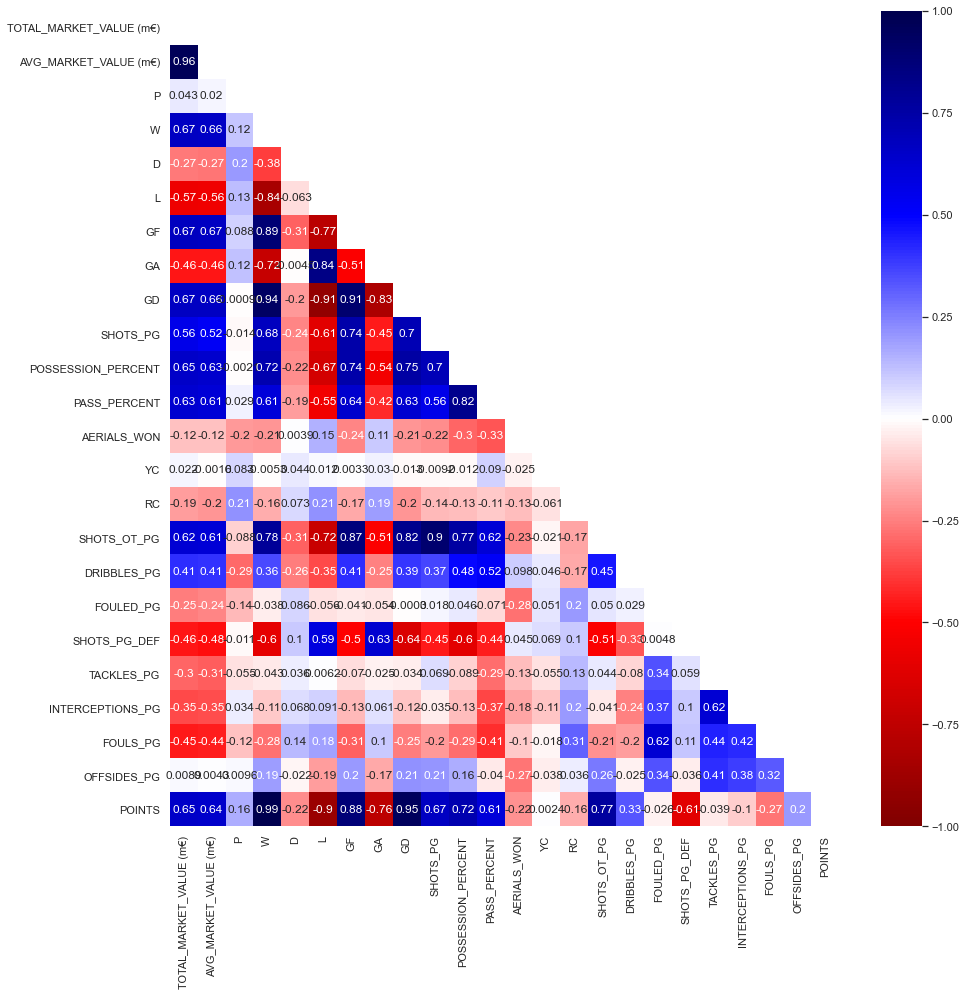

In [11]:
# View Heat Map
f, ax = plt.subplots(figsize=(15, 15))
upper = np.triu(new_leagues_df1.corr())  # optionally, you can just look at the lower triangle
sns.heatmap(new_leagues_df1.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper);

In [12]:
# Get correlations with POINTS sorted in descending order
new_leagues_df1.corr()['POINTS'].sort_values(ascending=False)

POINTS                     1.000000
W                          0.986095
GD                         0.951966
GF                         0.878582
SHOTS_OT_PG                0.769370
POSSESSION_PERCENT         0.723507
SHOTS_PG                   0.670068
TOTAL_MARKET_VALUE (m€)    0.654807
AVG_MARKET_VALUE (m€)      0.644215
PASS_PERCENT               0.605015
DRIBBLES_PG                0.331405
OFFSIDES_PG                0.198271
P                          0.157291
YC                         0.002395
FOULED_PG                 -0.025595
TACKLES_PG                -0.039438
INTERCEPTIONS_PG          -0.099773
RC                        -0.157196
AERIALS_WON               -0.217659
D                         -0.221759
FOULS_PG                  -0.268825
SHOTS_PG_DEF              -0.612464
GA                        -0.763889
L                         -0.896866
Name: POINTS, dtype: float64

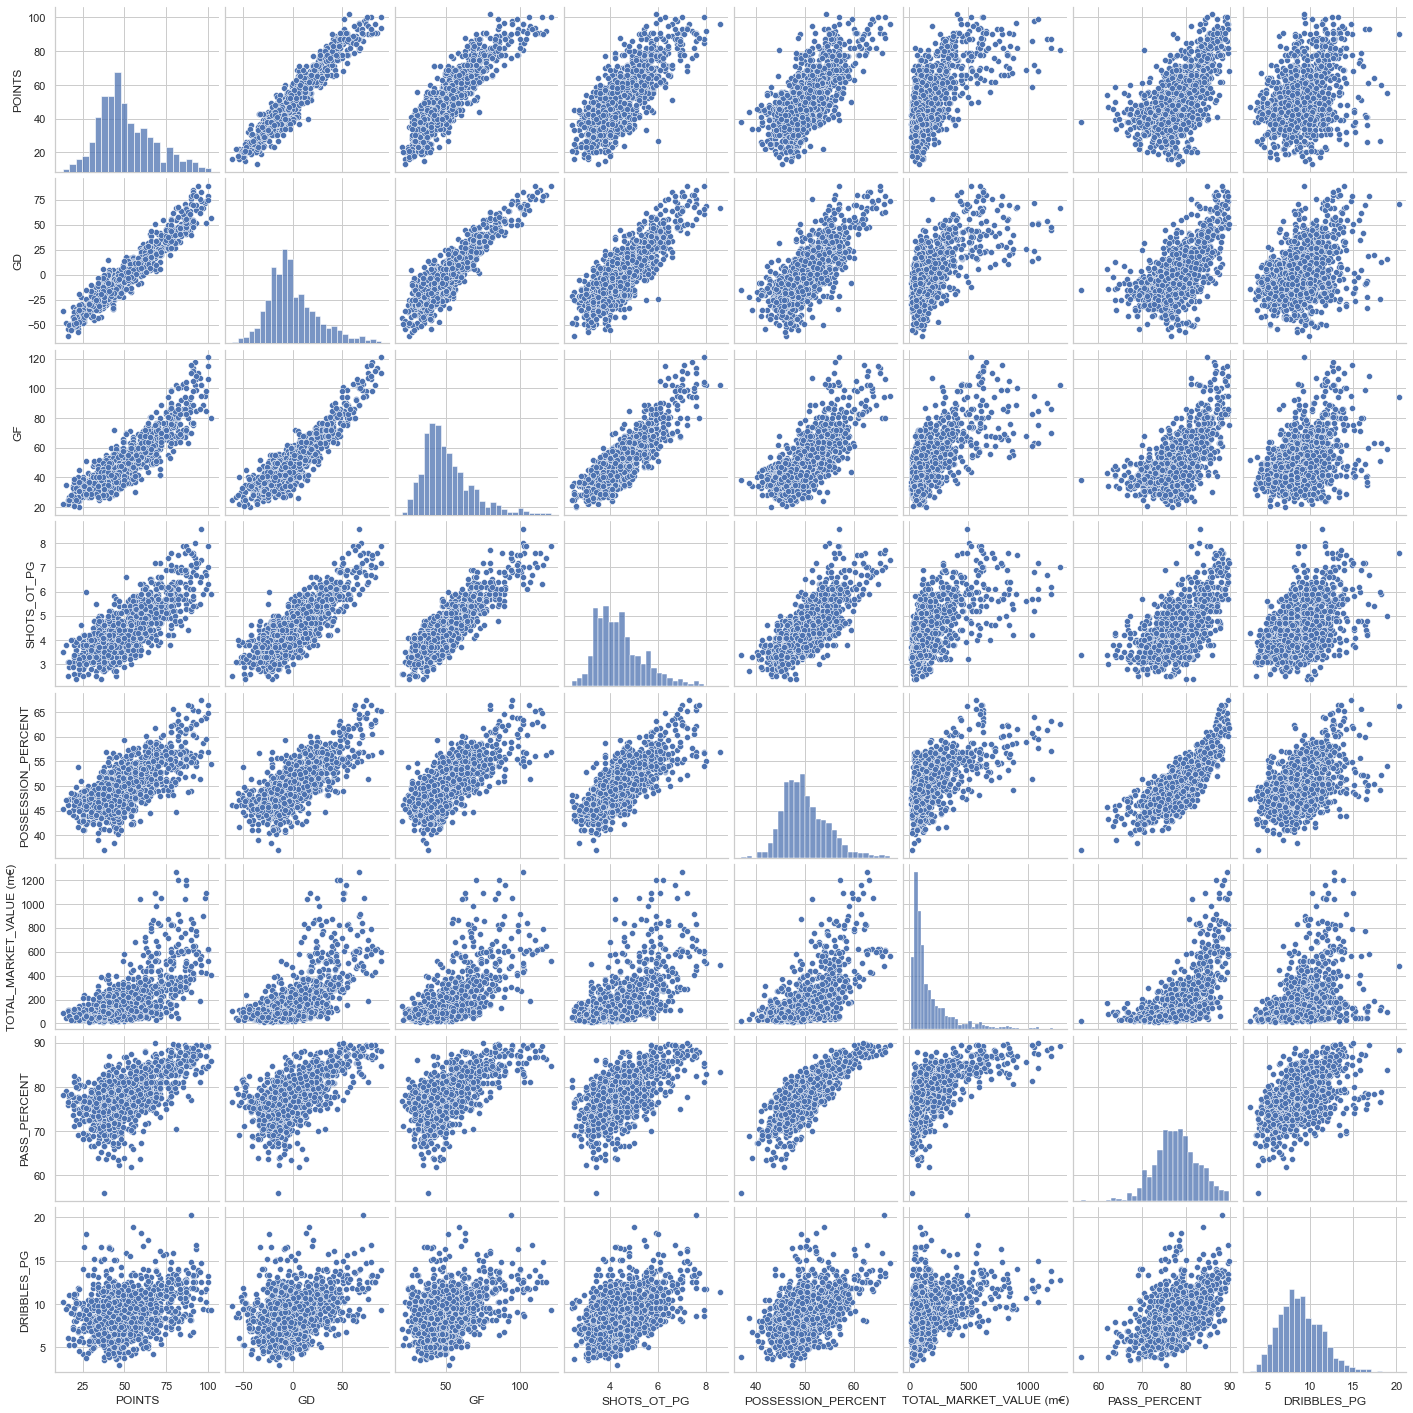

In [13]:
# Visualize some of the important pairwise correlations
sns.pairplot(new_leagues_df1[['POINTS','GD', 'GF', 'SHOTS_OT_PG', 'POSSESSION_PERCENT', 'TOTAL_MARKET_VALUE (m€)', 'PASS_PERCENT','DRIBBLES_PG']])

In [14]:
# Goal difference (GD) shows a strong linear relationship with POINTS
# Considering one feature - GOAL DIFFERENCE
# GOAL DIFFERENCE vs POINTS

# 𝑌̂=𝛽̂0 + 𝛽̂1𝑋1

# Create an empty model
lr = LinearRegression()

X = new_leagues_df1['GD'].values.reshape(-1, 1)
y = new_leagues_df1['POINTS']
# Fit the model
lr.fit(X, y)

LinearRegression()

In [15]:
# Calculate R^2
# This implies that our model accounts for (R^2)% of the deviation of our y from the mean.
lr.score(X, y) # ==> 90.6% of the variance in y is captured/explained by the model.

0.9062387636512829

In [16]:
# Using statsmodel

# The Adjusted  𝑅^2 tries to limit overfitting by penalizing large coefficients and extra variables.
# It should not be used to evaluate a model on its own.
# It may be used as a measure of goodnes-of-fit to compare models

#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

#The result shows that for every Goal Difference, the number of points scored increases by 0.621 on average.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 1.135e+04
Date:                Wed, 09 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:40:27   Log-Likelihood:                -3583.8
No. Observations:                1176   AIC:                             7172.
Df Residuals:                    1174   BIC:                             7182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.9133      0.149    342.306      0.000      50.621      51.205
x1             0.6214      0.006    106.523      0.000       0.610       0.633
==============================================================================
Omnibus:                       10.522   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.016
Skew:                          -0.093   Prob(JB):                     0.000905
Kurtosis:                       3.501   Cond. No.                         25.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Diagnostics plotting

def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

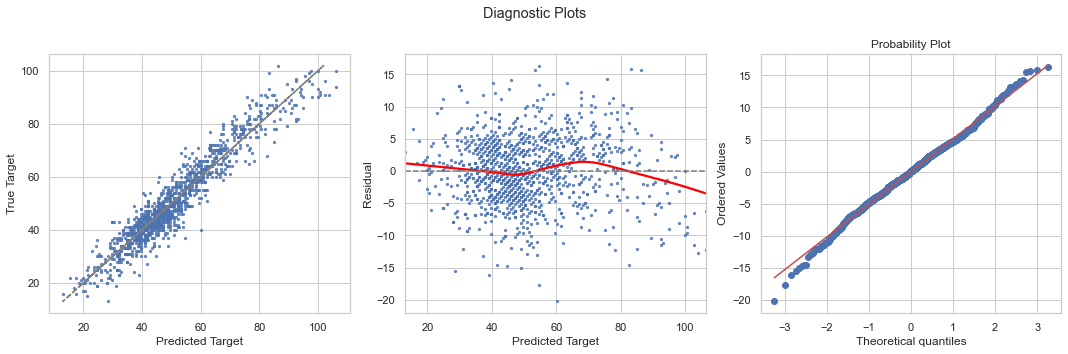

In [18]:
diagnostic_plots(fit.fittedvalues, y, fit.resid)

# The points appear to be well distrubuted around the gray line.
# The distribution of residual points from random fitting are randomly distributed around zero
# Points are very close to the line on the probability plot

In [19]:
# Considering one feature
# TOTAL_MARKET_VALUE vs POINTS

# 𝑌̂=𝛽̂0 + 𝛽̂1𝑋1

# Create an empty model
lr = LinearRegression()

X = new_leagues_df1['TOTAL_MARKET_VALUE (m€)'].values.reshape(-1, 1)
y = new_leagues_df1['POINTS']
# Fit the model
lr.fit(X, y)

LinearRegression()

In [20]:
lr.score(X, y)

0.4287720968690589

In [21]:
#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

#The result shows that for every 1 m€, the number of points scored increases by 0.0572 on average.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     881.2
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          6.27e-145
Time:                        11:40:28   Log-Likelihood:                -4646.3
No. Observations:                1176   AIC:                             9297.
Df Residuals:                    1174   BIC:                             9307.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.7747      0.501     81.318      0.000      39.791      41.759
x1             0.0572      0.002     29.685      0.000       0.053       0.061
==============================================================================
Omnibus:                        6.773   Durbin-Watson:                   0.887
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.672
Skew:                           0.173   Prob(JB):                       0.0356
Kurtosis:                       3.128   Cond. No.                         355.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

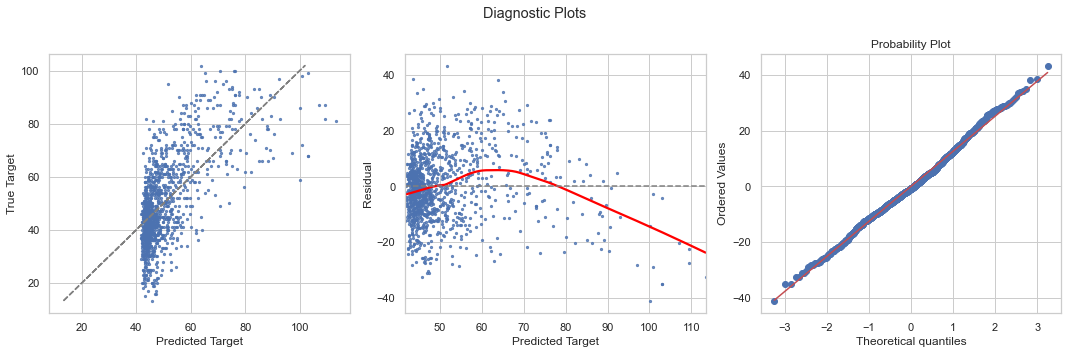

In [22]:
diagnostic_plots(fit.fittedvalues, y, fit.resid)

# Again, The points are distrubuted around the gray line.
# The distribution of residual points from random fitting are randomly distributed around zero.
# Points approach the line on the probability plot
# Also, a curvilinear relationship exists between the feature and the target.

In [23]:
#
# Based on the diagnostics plot, we can consider using a regression model
#
# Focus is on the correlation between squad value and total points.

# Adding multiple feature
# 𝑌̂=𝛽̂0+𝛽1𝑋1+𝛽̂2𝑋2 + ...

# Using 15 features that top the correlation matrix for POINTS
subset2=['GD','GF','SHOTS_OT_PG','POSSESSION_PERCENT','SHOTS_PG','TOTAL_MARKET_VALUE (m€)',
         'PASS_PERCENT','DRIBBLES_PG', 'OFFSIDES_PG','YC','FOULED_PG','TACKLES_PG',
         'INTERCEPTIONS_PG','RC','AERIALS_WON', 'POINTS']

new_leagues_df2 = new_leagues_df[subset2]
new_leagues_df2.head()

GD   GF  SHOTS_OT_PG  POSSESSION_PERCENT  SHOTS_PG  \
0  71  103          7.6                56.9      21.9   
1  58   86          5.8                55.6      18.3   
2  42   83          6.1                57.0      17.4   
3  26   67          5.9                52.2      17.9   
4  28   73          5.1                52.2      13.8   

   TOTAL_MARKET_VALUE (m€)  PASS_PERCENT  DRIBBLES_PG  OFFSIDES_PG  YC  \
0                   443.90          82.5          8.6          2.5  54   
1                   362.95          79.9          8.7          2.2  49   
2                   281.00          80.8         11.9          2.4  56   
3                   249.20          76.1          9.0          3.1  58   
4                   314.90          76.0          7.7          3.2  49   

   FOULED_PG  TACKLES_PG  INTERCEPTIONS_PG  RC  AERIALS_WON  POINTS  
0       12.3        20.3              18.6   5         11.6      86  
1       11.7        21.8              15.8   4         13.2      85  
2       14.0        21.5              22.1   1         14.4      75  
3       13.2        22.2              21.2   1         18.2      70  
4       12.8        21.1              21.2   2         12.7      67

In [24]:
new_leagues_df2.describe()

GD           GF  SHOTS_OT_PG  POSSESSION_PERCENT     SHOTS_PG  \
count  1176.000000  1176.000000  1176.000000         1176.000000  1176.000000   
mean      0.000000    50.521259     4.407143           49.999235    12.759779   
std      25.508847    16.694590     1.004619            4.511990     2.195769   
min     -61.000000    20.000000     2.400000           37.000000     7.100000   
25%     -17.000000    39.000000     3.700000           46.800000    11.200000   
50%      -5.000000    47.000000     4.200000           49.300000    12.300000   
75%      13.000000    59.000000     4.900000           52.700000    14.000000   
max      89.000000   121.000000     8.600000           67.400000    21.900000   

       TOTAL_MARKET_VALUE (m€)  PASS_PERCENT  DRIBBLES_PG  OFFSIDES_PG  \
count              1176.000000   1176.000000  1176.000000  1176.000000   
mean                177.211947     77.944218     8.860969     2.275680   
std                 190.570029      4.940904     2.528466     0.605805   
min                  13.750000     55.900000     3.000000     0.800000   
25%                  61.482500     74.900000     7.000000     1.900000   
50%                 105.390000     77.800000     8.600000     2.200000   
75%                 213.747500     81.200000    10.400000     2.600000   
max                1270.000000     89.900000    20.300000     4.600000   

                YC    FOULED_PG   TACKLES_PG  INTERCEPTIONS_PG           RC  \
count  1176.000000  1176.000000  1176.000000       1176.000000  1176.000000   
mean     62.529762    12.985629    18.872364         15.468878     3.880102   
std      23.393379     2.087198     2.764282          4.407495     2.268394   
min      10.000000     7.300000    12.000000          7.900000     0.000000   
25%      54.000000    11.500000    16.900000         11.900000     2.000000   
50%      65.500000    12.900000    18.900000         15.200000     4.000000   
75%      78.000000    14.400000    20.725000         18.200000     5.000000   
max      99.000000    21.900000    27.200000         36.800000     9.000000   

       AERIALS_WON       POINTS  
count  1176.000000  1176.000000  
mean     15.937840    50.913265  
std       4.784815    16.650376  
min       4.900000    13.000000  
25%      12.800000    40.000000  
50%      15.700000    47.000000  
75%      18.500000    61.000000  
max      36.000000   102.000000

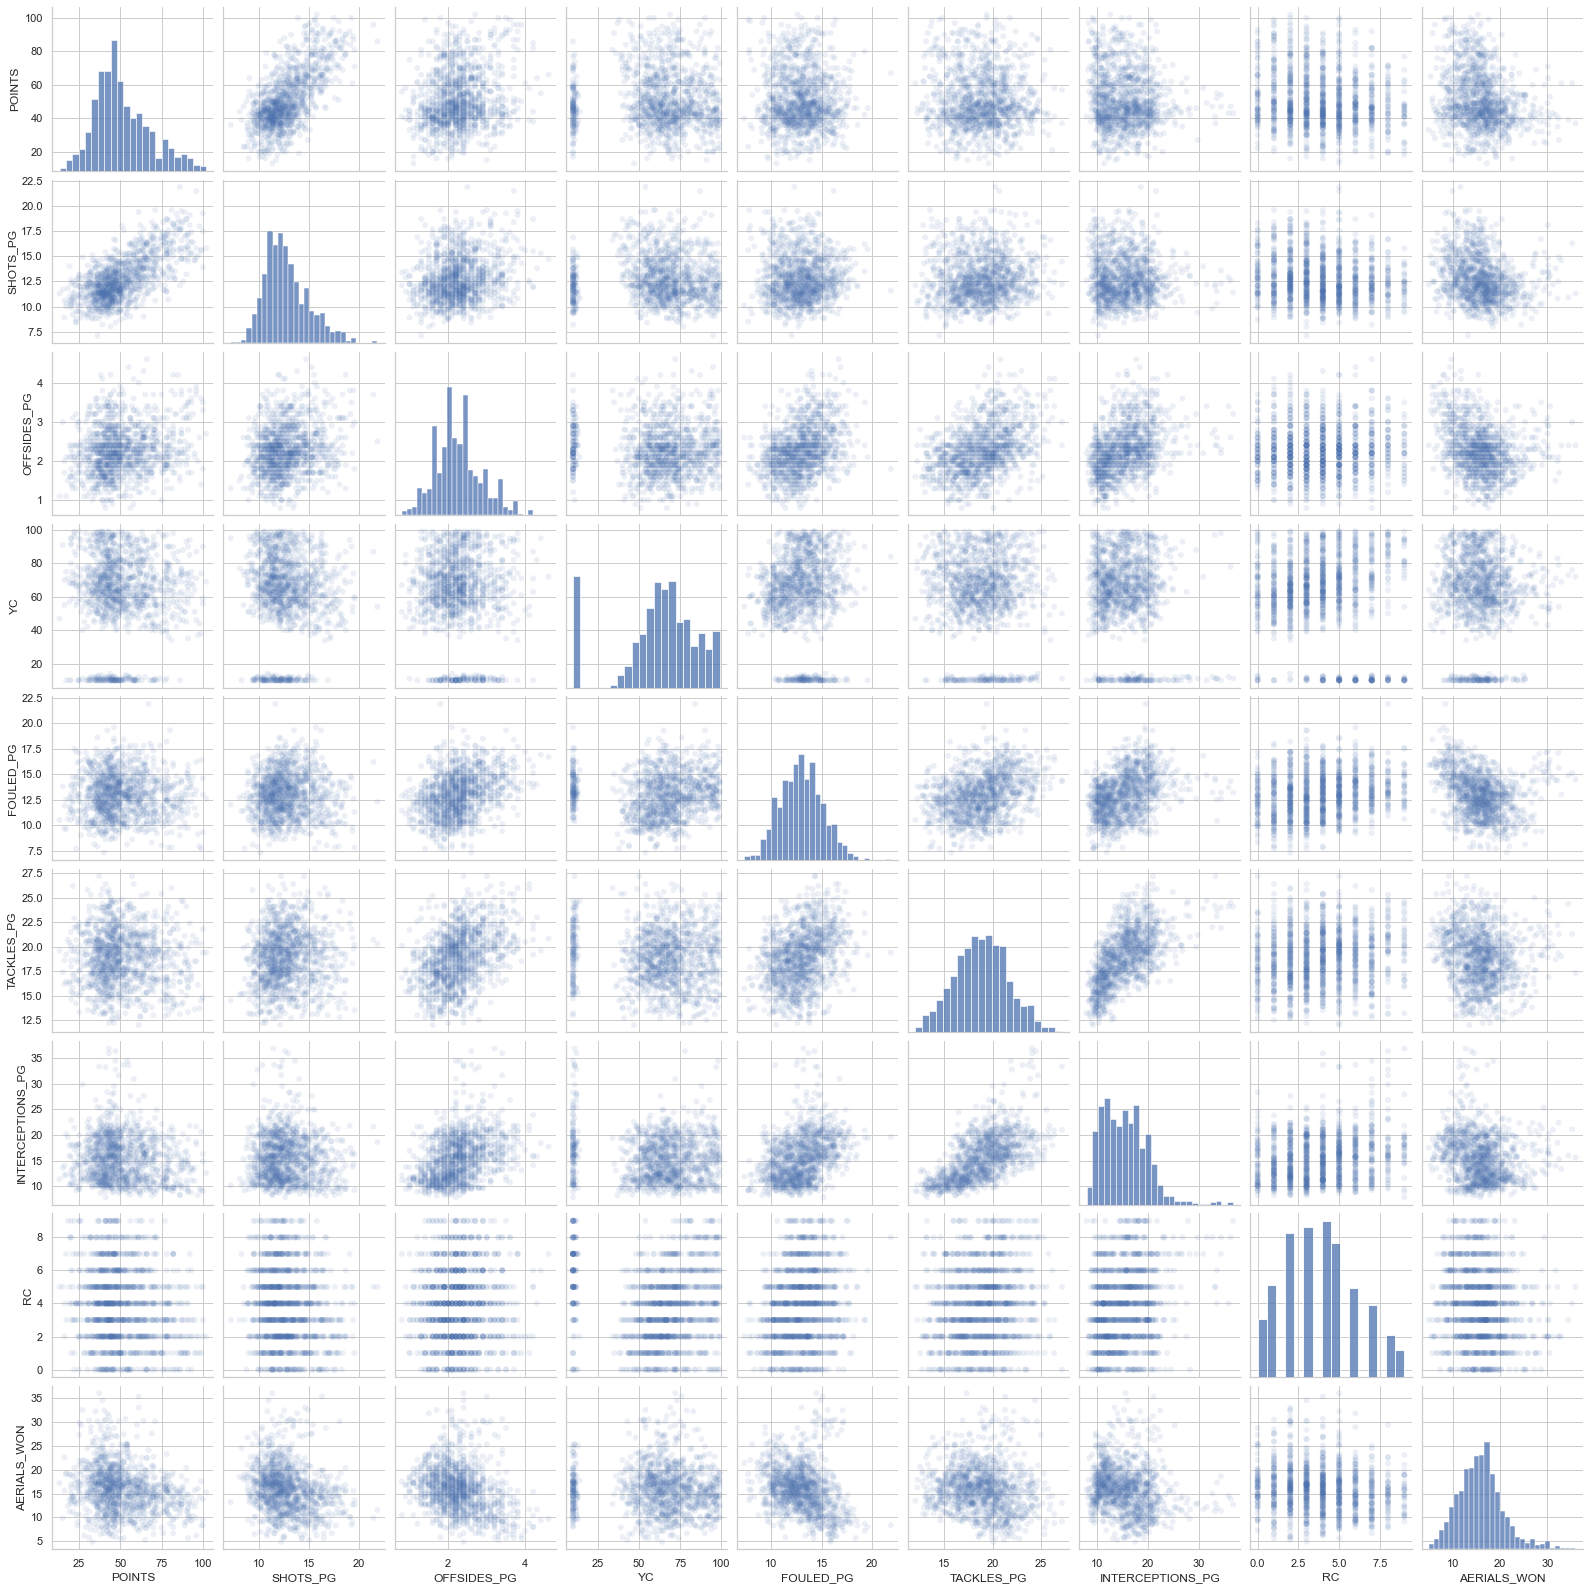

In [25]:
# Visualize some of the important pairwise correlations
sns.pairplot(new_leagues_df2[['POINTS', 'SHOTS_PG', 'OFFSIDES_PG','YC','FOULED_PG','TACKLES_PG',
                              'INTERCEPTIONS_PG','RC','AERIALS_WON']],plot_kws=dict(alpha=.1, edgecolor='none'))

In [26]:
#
# Apply OLS
#

X = new_leagues_df2.drop('POINTS',axis=1) # or new_leagues_df2[['X1','X2','X3',---]]
y = new_leagues_df2['POINTS']

#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     835.5
Date:                Wed, 09 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:40:50   Log-Likelihood:                -3524.2
No. Observations:                1176   AIC:                             7080.
Df Residuals:                    1160   BIC:                             7161.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      38.7417      4.739      8.175      0.000      29.444      48.040
GD                          0.5714      0.014     40.016      0.000       0.543       0.599
GF                          0.1433      0.025      5.815      0.000       0.095       0.192
SHOTS_OT_PG                -2.0314      0.478     -4.251      0.000      -2.969      -1.094
POSSESSION_PERCENT          0.0480      0.073      0.659      0.510      -0.095       0.191
SHOTS_PG                    0.2876      0.156      1.847      0.065      -0.018       0.593
TOTAL_MARKET_VALUE (m€)     0.0033      0.001      2.738      0.006       0.001       0.006
PASS_PERCENT                0.1024      0.064      1.595      0.111      -0.024       0.228
DRIBBLES_PG                -0.3587      0.076     -4.747      0.000      -0.507      -0.210
OFFSIDES_PG                -0.0639      0.288     -0.222      0.824      -0.629       0.501
YC                          0.0119      0.006      1.899      0.058      -0.000       0.024
FOULED_PG                  -0.1513      0.084     -1.794      0.073      -0.317       0.014
TACKLES_PG                  0.0297      0.072      0.414      0.679      -0.111       0.170
INTERCEPTIONS_PG            0.1228      0.047      2.619      0.009       0.031       0.215
RC                          0.2333      0.067      3.459      0.001       0.101       0.366
AERIALS_WON                 0.0268      0.038      0.704      0.482      -0.048       0.102
==============================================================================
Omnibus:                        7.817   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               10.578
Skew:                           0.011   Prob(JB):                      0.00505
Kurtosis:                       3.464   Cond. No.                     9.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
#
# Feature Engineering to improve Validation R^2
# BASELINE REGRESSION
#-----------------------------------------------

def split_and_validate_k(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # hold out 20% of the data for final testing
    # Train + Validation (80%) / Test(20%)
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42) # state = 10

    # further partition X, y into datasets X_train, y_train (60% of original) and X_val, y_val (20%).
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=12)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    train_score = lr_model.score(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nTrain R^2 score was     :', train_score)
    print('\nValidation R^2 score was:', val_score)
    print('\ny-intercept:', lr_model.intercept_)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    
    y_train_pred = lr_model.predict(X_train)
    y_test_pred  = lr_model.predict(X_test)
     
    sns.set_theme(style="white")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Train vs. Fitted
    axes[0].scatter(y_train, y_train_pred, alpha=0.2)
    axes[0].plot([0,110],[0,110])
    axes[0].set_xlabel('Train Target')
    axes[0].set_ylabel('Predicted Target')
    axes[0].set_title("Train Target vs. Predicted Target")
    
    # Test vs. Fitted
    axes[1].scatter(y_test, y_test_pred)
    axes[1].plot([0,110],[0,110])
    axes[1].set_xlabel('Test Target')
    axes[1].set_ylabel('Predicted Target')
    axes[1].set_title("Test Target vs. Predicted Target")
    
    # Plot Residuals vs. predicted
    lin_reg_residuals = y_train - y_train_pred

    axes[2].scatter(y_train_pred, lin_reg_residuals, alpha=0.2)
    axes[2].plot([0,110], [0, 0])
    axes[2].set_xlabel('Train Target')
    axes[2].set_ylabel('Residual')
    axes[2].set_title("Predictions vs. Residuals")

    #fig.suptitle('Diagnostic Plots');
    fig.tight_layout();   
        
#----------------------------------------------------------------------------------------------------
# Finally, run the lines below after you get max VALIDATION R^2 Score from doing FEATURE ENGINEERING
#----------------------------------------------------------------------------------------------------
## Retrain it on the entire chunk of train/val data (X,y) and see how it does on test data(X_test,y_test):
#    
#lr_model.fit(X,y)
#print(f'Linear Regression train/val R^2: {lr_model.score(X, y):.3f}')
#print(f'Linear Regression test R^2: {lr_model.score(X_test, y_test):.3f}')

def split_and_validate_k_test(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # hold out 20% of the data for final testing
    # Train + Validation (80%) / Test(20%)
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42) # state = 10

    # further partition X, y into datasets X_train, y_train (60% of original) and X_val, y_val (20%).
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=12)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    train_score = lr_model.score(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nTrain R^2 score was     :', train_score)
    print('\nValidation R^2 score was:', val_score)
    print('\ny-intercept:', lr_model.intercept_)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    
    y_train_pred = lr_model.predict(X_train)
    y_test_pred  = lr_model.predict(X_test)
    
    sns.set_theme(style="white")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Train vs. Fitted
    axes[0].scatter(y_train, y_train_pred, alpha=0.2)
    axes[0].plot([0,110],[0,110])
    axes[0].set_xlabel('Train Target')
    axes[0].set_ylabel('Predicted Target')
    axes[0].set_title("Train Target vs. Predicted Target")
    
    # Test vs. Fitted
    axes[1].scatter(y_test, y_test_pred)
    axes[1].plot([0,110],[0,110])
    axes[1].set_xlabel('Test Target')
    axes[1].set_ylabel('Predicted Target')
    axes[1].set_title("Test Target vs. Predicted Target")
    
    # Plot Residuals vs. predicted
    lin_reg_residuals = y_train - y_train_pred

    axes[2].scatter(y_train_pred, lin_reg_residuals, alpha=0.2)
    axes[2].plot([0,110], [0, 0])
    axes[2].set_xlabel('Train Target')
    axes[2].set_ylabel('Residual')
    axes[2].set_title("Predictions vs. Residuals")

    #fig.suptitle('Diagnostic Plots');
    fig.tight_layout();
    #----------------------------------------------------------------------------------------------------
    # Finally, run this function after you get max VALIDATION R^2 Score from doing FEATURE ENGINEERING
    #----------------------------------------------------------------------------------------------------
    # Retrain it on the entire chunk of train/val data (X,y) and see how it does on test data(X_test,y_test):

    lr_model.fit(X,y)
    y_train_val_pred = lr_model.predict(X)
    y_test_pred  = lr_model.predict(X_test) 
    residual_test = y_test - y_test_pred

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    g1 = sns.distplot(residual_test, bins = 50, ax=axes[0])
    stats.probplot(residual_test, dist="norm", plot=axes[1])
    axes[1].set_title('Norman Q-Q plot')

    fig.tight_layout();
    
    # prediction on trainig model
    RMSE = sqrt(mean_squared_error(y,y_train_val_pred))
    MAE  = mean_absolute_error(y,y_train_val_pred)
    # rediction on test model
    RMSE1 = sqrt(mean_squared_error(y_test,y_test_pred))
    MAE1   = mean_absolute_error(y_test,y_test_pred)

    print(f'\nLinear Regression (train/val) R^2: {lr_model.score(X, y):.3f}')
    print(f'Linear Regression test R^2     : {lr_model.score(X_test, y_test):.3f}')
    
    print(f'\nRoot Mean Square (RMSE) (train/val): {RMSE:.3f}')
    print(f'Root Mean Square (RMSE) test         : {RMSE1:.3f}')
    
    print(f'\nMean Absolute Error (MAE) (train/val): {MAE:.3f}')
    print(f'Mean Absolute Error (MAE) test         : {MAE1:.3f}')


Train R^2 score was     : 0.909822579489721

Validation R^2 score was: 0.9191974396753101

y-intercept: 36.814297237264256
Feature coefficient results: 

GD : 0.54
GF : 0.17
SHOTS_OT_PG : -2.63
POSSESSION_PERCENT : 0.13
SHOTS_PG : 0.41
TOTAL_MARKET_VALUE (m€) : 0.01
PASS_PERCENT : 0.04
DRIBBLES_PG : -0.27
OFFSIDES_PG : -0.45
YC : 0.01
FOULED_PG : -0.12
TACKLES_PG : 0.05
INTERCEPTIONS_PG : 0.20
RC : 0.19
AERIALS_WON : 0.06


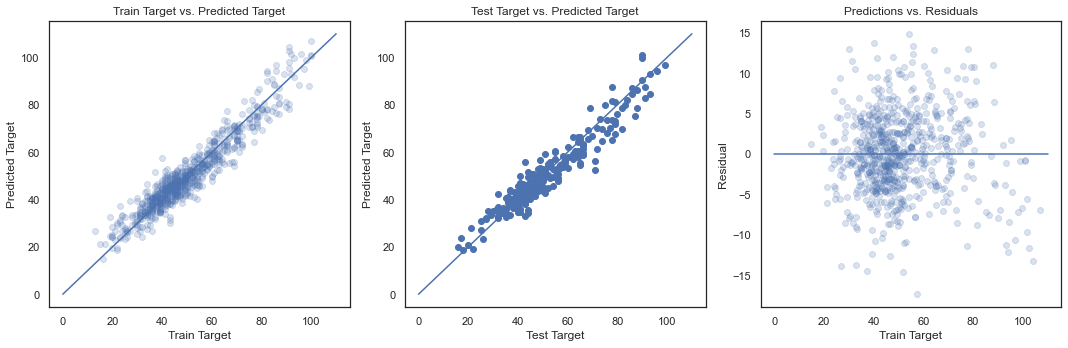

In [28]:
# Split and validate #1

X = new_leagues_df2.drop('POINTS',axis=1) # or new_leagues_df2[['X1','X2','X3',---]]
y = new_leagues_df2['POINTS']
split_and_validate_k(X, y)


Train R^2 score was     : 0.9098535908550918

Validation R^2 score was: 0.9191491834221106

y-intercept: 19.61443270245585
Feature coefficient results: 

GD : 0.54
GF : 0.17
SHOTS_OT_PG : -2.64
POSSESSION_PERCENT : 0.14
SHOTS_PG : 0.41
TOTAL_MARKET_VALUE (m€) : 0.01
PASS_PERCENT : 0.49
DRIBBLES_PG : -0.27
OFFSIDES_PG : -0.47
YC : 0.01
FOULED_PG : -0.12
TACKLES_PG : 0.04
INTERCEPTIONS_PG : 0.20
RC : 0.19
AERIALS_WON : 0.06
PASS_PERCENT2 : -0.00


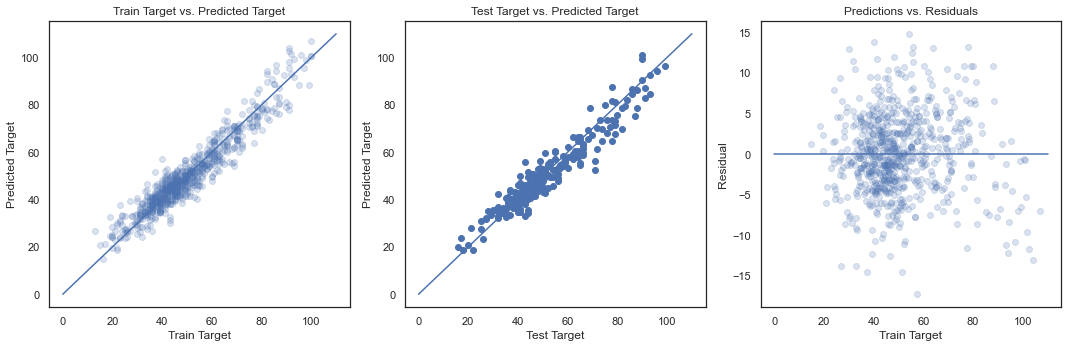

In [29]:
# Split and validate #2 - Adding polynomial term
# PASS PERCENT looks like a 2nd order polynomial function

X2 = X.copy()
X2['PASS_PERCENT2'] = X2['PASS_PERCENT'] ** 2

split_and_validate_k(X2, y) # Validation R^2 did not improve. R^2 went down. Poly function will be ignored


Train R^2 score was     : 0.9098255572043742

Validation R^2 score was: 0.9193859286401059

y-intercept: 36.637087889187946
Feature coefficient results: 

GD : 0.54
GF : 0.17
SHOTS_OT_PG : -2.63
POSSESSION_PERCENT : 0.13
SHOTS_PG : 0.41
TOTAL_MARKET_VALUE (m€) : 0.01
PASS_PERCENT : 0.04
DRIBBLES_PG : -0.27
OFFSIDES_PG : -0.45
YC : 0.01
FOULED_PG : -0.12
TACKLES_PG : 0.05
INTERCEPTIONS_PG : 0.20
RC : 0.19
AERIALS_WON : 0.06
TOTAL_MARKET_VALUE (m€)_LOG : 0.17


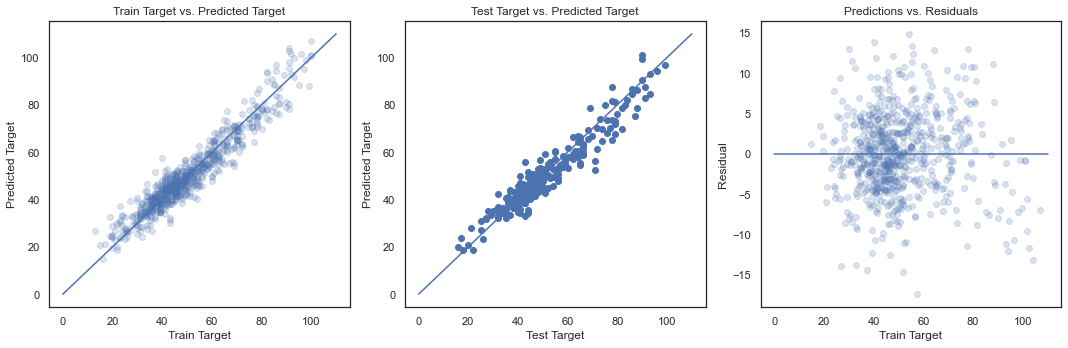

In [30]:
# Split and validate #3 - Adding logarithmic term
# TOTAL_MARKET_VALUE (m€) looks like a logarithmic function

X3 = X.copy()
#X3['TOTAL_MARKET_VALUE (m€)_LOG'] = np.log(X3['TOTAL_MARKET_VALUE (m€)'])   # log_e = ln ---> 0.9193859286401057
X3['TOTAL_MARKET_VALUE (m€)_LOG'] = np.log10(X3['TOTAL_MARKET_VALUE (m€)']) # log_10      ---> 0.9193859286401059
#X3['TOTAL_MARKET_VALUE (m€)_LOG'] = np.log2(X3['TOTAL_MARKET_VALUE (m€)'])  # log_2      ---> 0.9193859286401059

split_and_validate_k(X3, y) # Validation R^2 improved slightly.


Train R^2 score was     : 0.914062880547752

Validation R^2 score was: 0.9213417669277635

y-intercept: 10.96535687819862
Feature coefficient results: 

GD : 0.54
GF : -0.39
SHOTS_OT_PG : -2.44
POSSESSION_PERCENT : 0.12
SHOTS_PG : 2.66
TOTAL_MARKET_VALUE (m€) : 0.01
PASS_PERCENT : 0.01
DRIBBLES_PG : -0.22
OFFSIDES_PG : -0.41
YC : 0.01
FOULED_PG : -0.15
TACKLES_PG : 0.02
INTERCEPTIONS_PG : 0.20
RC : 0.22
AERIALS_WON : 0.05
TOTAL_MARKET_VALUE (m€)_LOG : -0.91
GF_/SHOTS_PG : 7.35


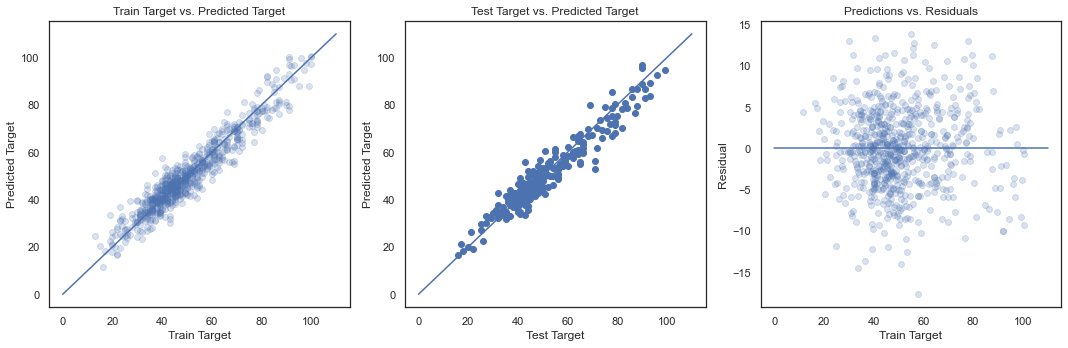

In [31]:
# Split and validate #4 - Adding division interaction

X4 = X3.copy()

X4['GF_/SHOTS_PG'] = X4['GF']/X4['SHOTS_PG'] # Goals scored/shots_pg

split_and_validate_k(X4, y) # Validation R^2 improved R^2


Train R^2 score was     : 0.914062880547752

Validation R^2 score was: 0.9213417669277635

y-intercept: 10.96535687819862
Feature coefficient results: 

GD : 0.54
GF : -0.39
SHOTS_OT_PG : -2.44
POSSESSION_PERCENT : 0.12
SHOTS_PG : 2.66
TOTAL_MARKET_VALUE (m€) : 0.01
PASS_PERCENT : 0.01
DRIBBLES_PG : -0.22
OFFSIDES_PG : -0.41
YC : 0.01
FOULED_PG : -0.15
TACKLES_PG : 0.02
INTERCEPTIONS_PG : 0.20
RC : 0.22
AERIALS_WON : 0.05
TOTAL_MARKET_VALUE (m€)_LOG : -0.91
GF_/SHOTS_PG : 7.35

Linear Regression (train/val) R^2: 0.917
Linear Regression test R^2     : 0.926

Root Mean Square (RMSE) (train/val): 4.761
Root Mean Square (RMSE) test         : 4.639

Mean Absolute Error (MAE) (train/val): 3.735
Mean Absolute Error (MAE) test         : 3.693


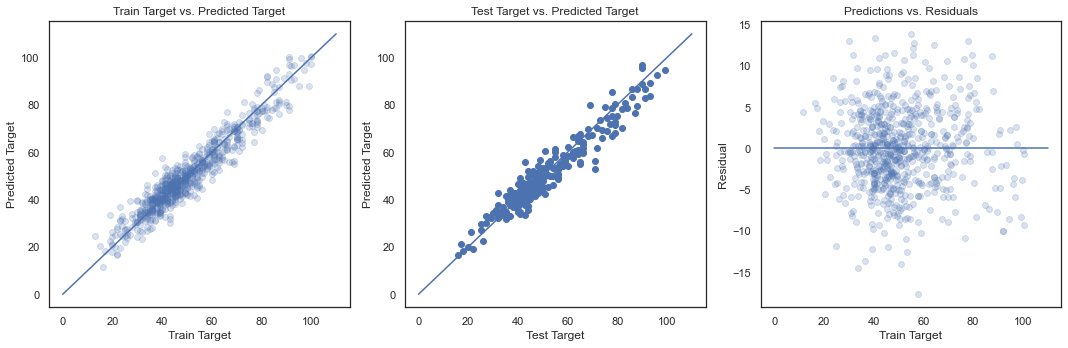

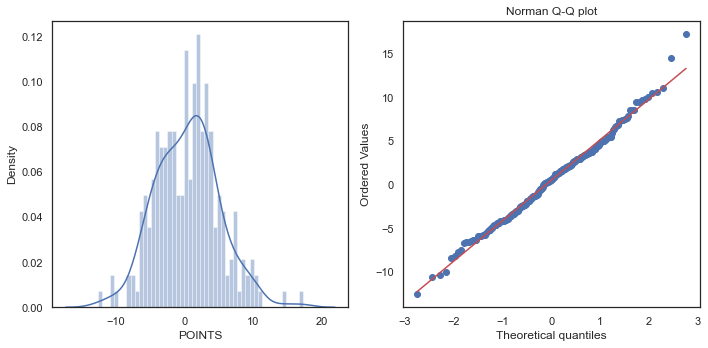

In [32]:
# So far our validation R^2 looks good. 
# Test model on (train/validate) combo, and score the test set

split_and_validate_k_test(X4, y) # This shows a good fit between (train/val)(0.917) and test data (0.926)
# Notice that the residual has a normal distribution and the range is tight.

In [33]:
# Mean Absolute Error

'''
Root Mean Square (RMSE) (train/val): 4.761
Root Mean Square (RMSE) test         : 4.639

Mean Absolute Error (MAE) (train/val): 3.735
Mean Absolute Error (MAE) test         : 3.693
'''

# Thus, the prediction is within +/- 5 points of the actual points


'\nRoot Mean Square (RMSE) (train/val): 4.761\nRoot Mean Square (RMSE) test         : 4.639\n\nMean Absolute Error (MAE) (train/val): 3.735\nMean Absolute Error (MAE) test         : 3.693\n'

In [34]:
#
# Simple validation method: Train(60%) / Validation(20%) / Test(20%)
# RIDGE REGRESSION: alpha = 1.0

X, y = new_leagues_df2.drop('POINTS',axis=1), new_leagues_df2['POINTS']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=11) # state = 10

# Partition once more to get 20% of training
# further partition X, y into datasets X_train, y_train (60% of original) and X_val, y_val (20%).
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [35]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each feature
poly = PolynomialFeatures(degree=1) 

X_train_poly = poly.fit_transform(X_train.values) # Fits data and then transforms it.
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [36]:
# validate

lm.fit(X_train, y_train)

print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression train R^2: 0.911
Linear Regression val R^2: 0.924
Ridge Regression val R^2: 0.924
Degree 2 polynomial regression val R^2: 0.924


In [37]:
# Retrain it on the entire chunk of train/val data (X,y) and see how it does on test data(X_test,y_test):
    
lm.fit(X,y)
print(f'Linear Regression train/val R^2: {lm.score(X, y):.3f}')
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression train/val R^2: 0.915
Linear Regression test R^2: 0.915


In [38]:
# For the Ridge regression approach with alpha = 1.0,
# Degrees = 1, R^2 = 0.915, 0.915
# Degrees = 1, R^2 = 0.915, 0.915. 
# Since there is no change with degrees 2 polynomial, stick with degree 1 polynomial.

In [39]:
#-------------------------
# SIMPLE and RIDGE CV
#-------------------------

X = new_leagues_df2.drop('POINTS',axis=1) # or new_leagues_df2[['X1','X2','X3',---]]
y = new_leagues_df2['POINTS']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [40]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val).round(3))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val).round(3))

print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Ridge scores: \t{cv_lm_reg_r2s} \n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple scores: 	[0.932, 0.924, 0.924, 0.895, 0.887]
Ridge scores: 	[0.932, 0.924, 0.924, 0.895, 0.887] 

Simple mean cv r^2: 0.912 +- 0.018
Ridge mean cv r^2: 0.912 +- 0.018


In [41]:
# Get a Ridge model from train/val (X) and score test(X_test)
# Overall, k-fold is more reliable than a single validation set, 
# we select the ridge regression model

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.905


In [42]:
#-------------------------
# SIMPLE and RIDGE CV on X4 with the added features
#-------------------------

X = X4                        # new_leagues_df2.drop('POINTS',axis=1) # or new_leagues_df2[['X1','X2','X3',---]]
y = new_leagues_df2['POINTS']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [43]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val).round(3))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val).round(3))

print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Ridge scores: \t{cv_lm_reg_r2s} \n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple scores: 	[0.932, 0.923, 0.927, 0.899, 0.897]
Ridge scores: 	[0.933, 0.923, 0.927, 0.899, 0.896] 

Simple mean cv r^2: 0.916 +- 0.015
Ridge mean cv r^2: 0.916 +- 0.015


In [44]:
# Get a Ridge model from train/val (X) and score test(X_test)
# Overall, k-fold is more reliable than a single validation set, 
# we select the ridge regression model

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.911


In [45]:
# Notice the improvement in R^2 from 0.906 to 0.911. Thus Ridge CV is better.
# Next, perform regularization using RuDGECV and LASSO CV and pick out the better model based on MAE

In [46]:
#-----------------
# REGULARIZATION
#-----------------
# Practical strategy for reducing overfitting by punishing model complexity.
# We search for a model that is elaborate enough to describe the feature-target relationship (not underfit), 
# but not so elaborate that it fits to spurious patterns in the training data (not overfit)

X = X4
y = new_leagues_df2['POINTS']

#Split the data 60 - 20 - 20 train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [47]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

Minimum Error : 3.872429774712259
Alpha with minimum error : 0.01


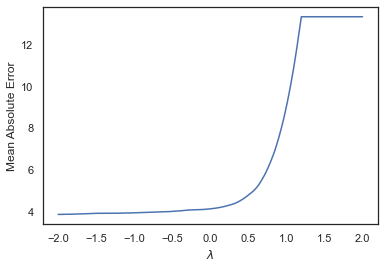

In [48]:
#------------------------------------------------------
# Tuning Regularization Strength via Validation - LASSO
#------------------------------------------------------

# Combine standard scaling
# Apply scalar to training and test data sets,
# Fit LASSO/RIDGE model

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)
    
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)
plt.xlabel (r'$\lambda$')
plt.ylabel('Mean Absolute Error')

## Minimum error achieved on the validation set across the different alpha values we tried

print(f'Minimum Error : {np.min(err_vec_val)}')

## This is the value of alpha that gave us the lowest error
print(f'Alpha with minimum error : {alphalist[np.argmin(err_vec_val)]}')


Minimum Error : 3.85943999458295
Alpha with minimum error : 0.01


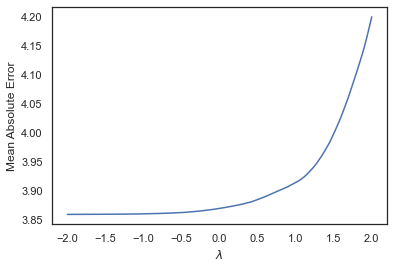

In [49]:
#------------------------------------------------------
# Tuning Regularization Strength via Validation - RIDGE
#------------------------------------------------------

# Combine standard scaling
# Apply scalar to training and test data sets,
# Fit LASSO/RIDGE model

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)
    
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)
plt.xlabel (r'$\lambda$')
plt.ylabel('Mean Absolute Error')

## Minimum error achieved on the validation set across the different alpha values we tried

print(f'Minimum Error : {np.min(err_vec_val)}')

## This is the value of alpha that gave us the lowest error
print(f'Alpha with minimum error : {alphalist[np.argmin(err_vec_val)]}')



In [50]:
#----------------------------------------------------------------------
# Automated Regularization Strength Tuning via Cross-validation - LASSO
#----------------------------------------------------------------------

## Scale the data
std = StandardScaler()
std.fit(X_train.values)

## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [51]:
# This is the best alpha value it found
# Compare with alpha from simple validation
print(f'Alpha with minimum error : {lasso_model.alpha_}') # this value is same as value from simple validation
print('\n')

# These are the (standardized) coefficients found when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

Alpha with minimum error : 0.01




[('GD', 13.95037315999874),
 ('GF', -3.403394837288003),
 ('SHOTS_OT_PG', -1.7808461216272962),
 ('POSSESSION_PERCENT', 0.6053494036232271),
 ('SHOTS_PG', 3.5960836264990292),
 ('TOTAL_MARKET_VALUE (m€)', 1.0955603021657314),
 ('PASS_PERCENT', 7.197463625878066e-05),
 ('DRIBBLES_PG', -0.7170568445600407),
 ('OFFSIDES_PG', -0.11602638016881482),
 ('YC', 0.11631334248874924),
 ('FOULED_PG', -0.19099262003376338),
 ('TACKLES_PG', -0.2879002831171765),
 ('INTERCEPTIONS_PG', 0.7354720056800794),
 ('RC', 0.527768868587281),
 ('AERIALS_WON', 0.1484578852341171),
 ('TOTAL_MARKET_VALUE (m€)_LOG', -0.0289471172943645),
 ('GF_/SHOTS_PG', 4.161497008114355)]

In [52]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

# Find the MAE and R^2 on the test set using this model
print(f'Mean Absolute Error on the test set with LASSO:  {mae(y_test, test_set_pred)}')

print(f'R2 score on the test set with LASSO: {r2_score(y_test, test_set_pred)}')

Mean Absolute Error on the test set with LASSO:  3.6869676975445755
R2 score on the test set with LASSO: 0.924931086461541


In [53]:
#----------------------------------------------------------------------
# Automated Regularization Strength Tuning via Cross-validation - RIDGE
#----------------------------------------------------------------------

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [54]:
print(f'Alpha with minimum error : {ridge_model.alpha_}') # this value is same as value from simple validation
print('\n')

# These are the (standardized) coefficients found when it refit using that best alpha
list(zip(X_train.columns, ridge_model.coef_))

Alpha with minimum error : 0.5872786613189482




[('GD', 13.979694569778534),
 ('GF', -4.555554032289953),
 ('SHOTS_OT_PG', -1.8657063265433897),
 ('POSSESSION_PERCENT', 0.6077594827731484),
 ('SHOTS_PG', 4.309952339241809),
 ('TOTAL_MARKET_VALUE (m€)', 1.2341851491715559),
 ('PASS_PERCENT', 0.04916423591541651),
 ('DRIBBLES_PG', -0.7233085804423224),
 ('OFFSIDES_PG', -0.10958264642301978),
 ('YC', 0.12745965515874264),
 ('FOULED_PG', -0.2072329625876179),
 ('TACKLES_PG', -0.31948115935921223),
 ('INTERCEPTIONS_PG', 0.7756576918945765),
 ('RC', 0.5386077090725149),
 ('AERIALS_WON', 0.17879937977652424),
 ('TOTAL_MARKET_VALUE (m€)_LOG', -0.18697777863731024),
 ('GF_/SHOTS_PG', 4.962423596606303)]

In [55]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

# Find the MAE and R^2 on the test set using this model
print(f'Mean Absolute Error on the test set with RIDGE:  {mae(y_test, test_set_pred)}')

print(f'R2 score on the test set with RIDGE: {r2_score(y_test, test_set_pred)}')

Mean Absolute Error on the test set with RIDGE:  3.6778740108944348
R2 score on the test set with RIDGE: 0.925290115108806


In [56]:
#-------------------------------------------
# LARS Path to Study Feature Importance
#-------------------------------------------

## Scale the variables
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [57]:
X_tr = std.transform(X_train.values)

## Note: lars_path takes numpy matrices, not pandas dataframes
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


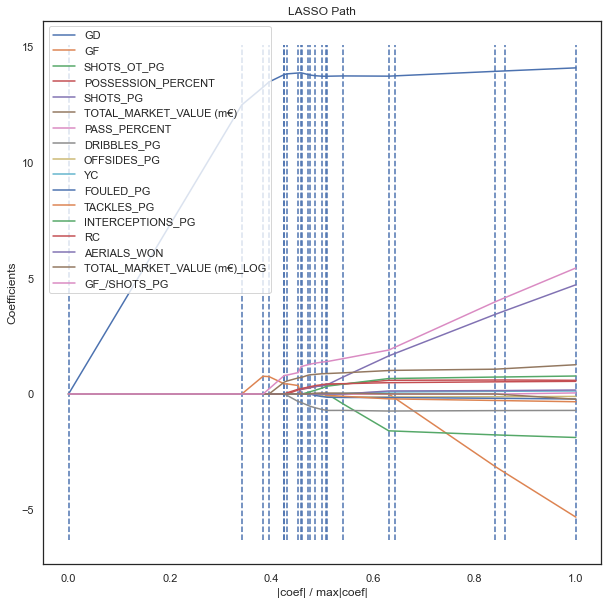

In [58]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [ ]:
#
# POLYNOMIAL FEATURES
#
# For any two features x and y, we can suspect that thereis a polynomial relationship such as x^2 + xy + y^2
# Consider each term to be a feature. Thus we have three new features. 
# The middle term xy is the interaction.
# the interaction could be addition, subtraction, or ratio.
# If using a ratio, add a small constant to the divisor and dividend to avoid dividing by zero.
# Rule of thumb: Avoid higher order polynomials and interactions of many features.

# Note that if validation scores from K-fold cross validation varies widely, 
# try simplifications like feature selection or regularization.


In [59]:
# Using the original dataset

X = new_leagues_df2.drop('POINTS',axis=1) # or new_leagues_df2[['X1','X2','X3',---]]
y = new_leagues_df2['POINTS']

# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.9139192627529245

In [60]:
# Score on validation set
lr.score(X_val,y_val)

0.9231586659180014

In [61]:
# See if polynomial features will do better.
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

0.8375076535636239

In [62]:
# Score on validation set
lr_poly.score(X_val_poly, y_val)

0.8045335933955777

In [64]:
#poly.get_feature_names()

# use LASSO to see important interactions

# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Apply the same scaler to val set
X_val_poly_scaled = scaler.transform(X_val_poly)

# Fit a LASSO model using polynomial features
lasso = LassoCV()
lasso.fit(X_train_poly_scaled,y_train)
lasso.score(X_train_poly_scaled,y_train)

0.9342043054773155

In [65]:
# Score on validation set
lasso.score(X_val_poly_scaled, y_val)

0.9280190053947248

In [66]:
list(zip(poly.get_feature_names(['x1','x2','x3','x4','x5','x6','x7','x8',\
                                 'x9','x10','x11','x12','x13','x14','x15']),lasso.coef_))

[('1', 0.0),
 ('x1', 10.924666660818552),
 ('x2', 4.008162679710029),
 ('x3', -0.0),
 ('x4', 0.009055734247952748),
 ('x5', -0.0),
 ('x6', 0.0),
 ('x7', -1.351659588089799),
 ('x8', 0.3712973911392462),
 ('x9', 1.9558091728937599),
 ('x10', -0.016888976362830068),
 ('x11', 0.0),
 ('x12', 0.0),
 ('x13', 0.0),
 ('x14', -0.0),
 ('x15', 0.0),
 ('x1^2', 1.6419497562281125),
 ('x1 x2', -0.0),
 ('x1 x3', -0.0),
 ('x1 x4', -0.27662900839776616),
 ('x1 x5', -0.0),
 ('x1 x6', -1.0067916884158046),
 ('x1 x7', 2.9625286904121237),
 ('x1 x8', -2.1310884566735178),
 ('x1 x9', 0.0),
 ('x1 x10', 2.330910725703989),
 ('x1 x11', 1.0224863301636353),
 ('x1 x12', 0.0),
 ('x1 x13', 0.0),
 ('x1 x14', 0.5219674269094313),
 ('x1 x15', -0.0),
 ('x2^2', -9.093021890543792),
 ('x2 x3', -0.0),
 ('x2 x4', -0.0),
 ('x2 x5', -0.0),
 ('x2 x6', -0.0),
 ('x2 x7', 7.8899886200122715),
 ('x2 x8', 0.0),
 ('x2 x9', -1.4311429487309968),
 ('x2 x10', -0.8811492950984283),
 ('x2 x11', 0.0),
 ('x2 x12', 0.0),
 ('x2 x13', 0.0),